In [59]:
import torch

ckpt_path = "../train/Log/spt_base/WatermarkTrainer_00005000.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("🔎 Checkpoint type:", type(ckpt))

if isinstance(ckpt, dict):
    print("✅ Keys in checkpoint:")
    for i, k in enumerate(ckpt.keys()):
        print(f"  {i+1}. {k}")
        if i >= 20:  # 最多只打印前 20 个 key
            break
else:
    print("⚠️ Checkpoint is not a dict, type:", type(ckpt))

🔎 Checkpoint type: <class 'dict'>
✅ Keys in checkpoint:
  1. embedder
  2. detectors
  3. optim_embedder
  4. optim_detectors
  5. scheduler_embedder
  6. scheduler_detectors
  7. best_dev_loss


In [60]:
from watermark import embed_watermark, decode_watermark

In [61]:
from audio import load_audio, play_audio, plot_waveform_and_specgram
#
# waveform, sr = load_audio("../audios/1.wav", target_sr=16000)
# print(waveform.shape, sr)

In [99]:
import torch
import torchaudio
import urllib

def download_sample_audio():
    url = "https://keithito.com/LJ-Speech-Dataset/LJ037-0171.wav"
    with open("test.wav", "wb") as f:
        resp = urllib.request.urlopen(url)
        f.write(resp.read())

    wav, sample_rate = torchaudio.load("test.wav")
    return wav, sample_rate

audio, sr = download_sample_audio()
print(audio.shape, sr)

torch.Size([1, 167226]) 22050


/home/wu25/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/wu25/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. 

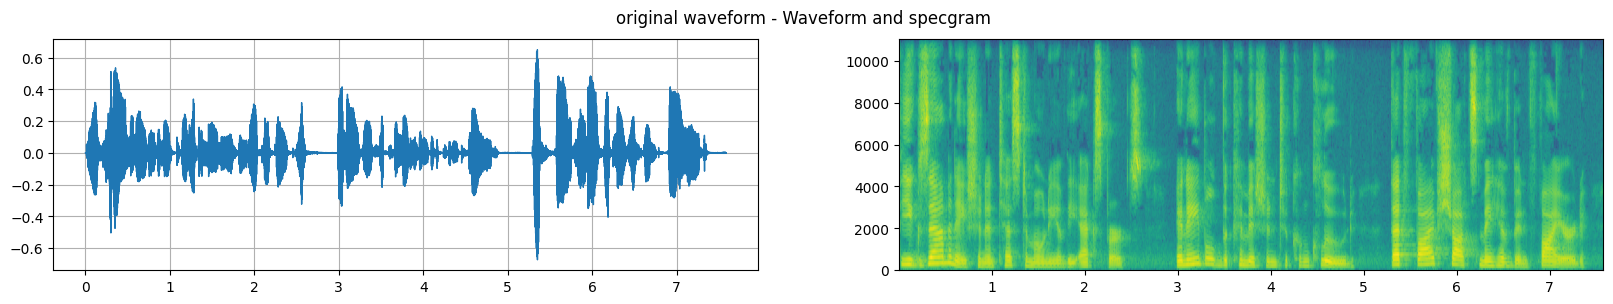


This is likely a watermarked audio: 0.0018776766955852509, message: 0000111001111111


In [100]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

plot_waveform_and_specgram(audio, sr, "original waveform")
result, message = decode_watermark(audio, sr)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")
play_audio(audio, sr)

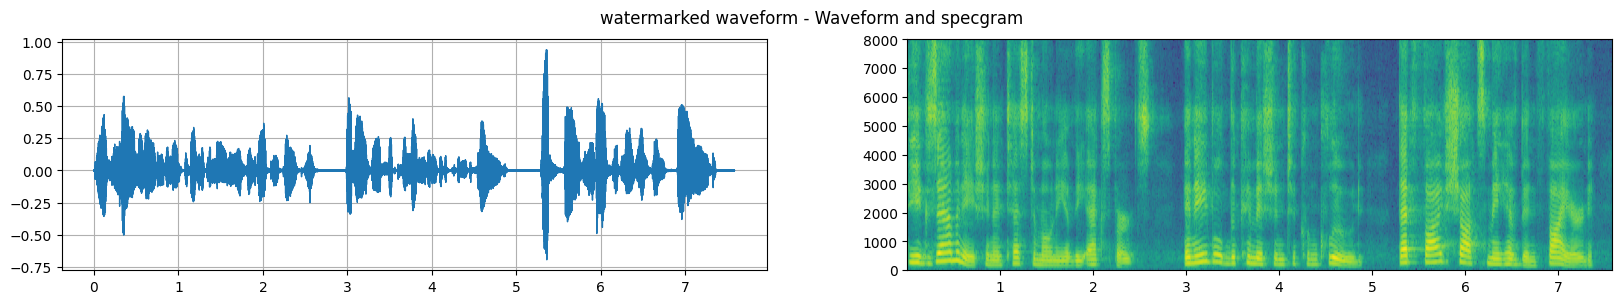


This is likely a watermarked audio: 0.8077108860015869, message: 1000010101010011


In [106]:
watermarked_audio = embed_watermark(audio, sample_rate=sr, message="1000010101010011")
play_audio(watermarked_audio, 16000)
plot_waveform_and_specgram(watermarked_audio, 16000, "watermarked waveform")
result, message = decode_watermark(watermarked_audio.squeeze(0), 16000)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [102]:
import soundfile as sf
import numpy as np

# 保存
sf.write("watermarked_audio.wav", watermarked_audio.cpu().numpy().squeeze().astype('float32'), 16000)
# 读取回来
import librosa
audio_np, _ = librosa.load("watermarked_audio.wav")
# watermarked_audio, sr = torchaudio.load("watermarked_audio.wav")
# diff = torch.abs(watermarked_audio - audio_np)
# print("平均差:", diff.mean(), "最大差:", diff.max())
# 转回 Tensor
watermarked_audio = torch.tensor(audio_np, dtype=torch.float32).unsqueeze(0)


In [103]:
# import torch
# import numpy as np

# def simulate_torchaudio_io(audio: torch.Tensor):
#     """
#     模拟 sf.write(... float32) + torchaudio.load(...) 的过程
#     """
#     # 转 numpy 1D
#     x = audio.detach().cpu().numpy()
#     if x.ndim == 2 and x.shape[0] == 1:
#         x = x.squeeze(0)
#     elif x.ndim > 2:
#         x = x.reshape(-1)

#     # clip 到 [-1,1]，模拟 float WAV 读取时可能发生的裁剪
#     x = np.clip(x, -1.0, 1.0)

#     # 强制 float32，模拟 float32 WAV 精度
#     x = x.astype(np.float32)

#     # 转回 tensor (模拟 torchaudio 的 channels-first)
#     x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # shape (1, n_samples)
#     return x_tensor

# # -------------------
# # 使用示例
# sim_audio = simulate_torchaudio_io(watermarked_audio)
# diff = (watermarked_audio - sim_audio).abs().mean().item()
# print("模拟 I/O 平均差:", diff)


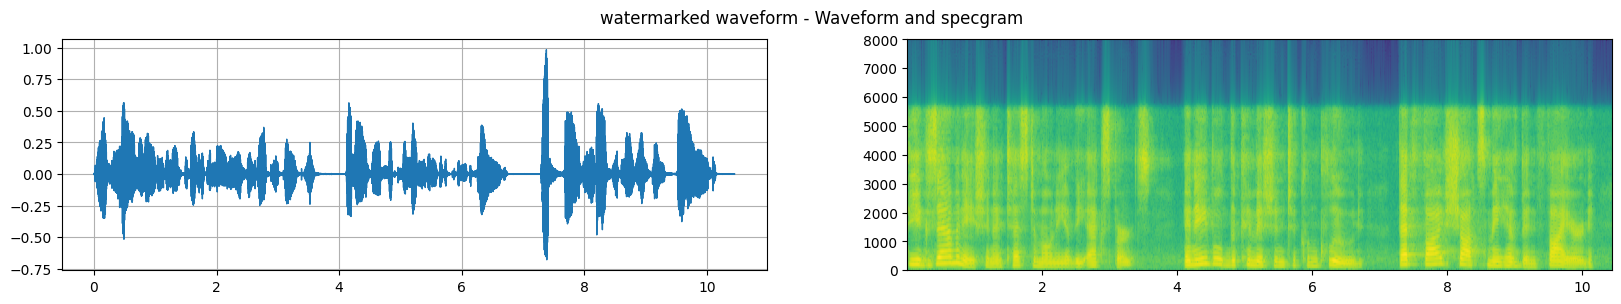


This is likely a watermarked audio: 0.9406332969665527, message: 1001011111110011


In [104]:
play_audio(watermarked_audio, 16000)
plot_waveform_and_specgram(watermarked_audio, 16000, "watermarked waveform")
result, message = decode_watermark(watermarked_audio, 16000)
print(f"\nThis is likely a watermarked audio: {result}, message: {message}")

In [ ]:
from example.attacks import AudioEffects as af

In [ ]:
speed = af.speed(watermarked_audio, sample_rate=sr, speed_range=(0.9, 1.1))
plot_waveform_and_specgram(speed, sample_rate=sr, title="Audio with speed filter")
play_audio(speed, sr)
result, message = decode_watermark(speed, sr)
print(f"Detection Result with Speed Filter: {result, message}")

### pitch shift

In [ ]:
import torch
import librosa
import numpy as np

def random_pitch_shift_tensor(audio_tensor, sr, n_semitones=5):
    """
    接受 PyTorch Tensor，返回 PyTorch Tensor
    """
    # 转 numpy
    audio_np = audio_tensor.cpu().numpy().squeeze(0)
    shift = np.random.uniform(-n_semitones, n_semitones)
    shifted_np = librosa.effects.pitch_shift(y=audio_np, sr=sr, n_steps=shift)
    # 转回 tensor
    shifted_tensor = torch.tensor(shifted_np, dtype=torch.float32).unsqueeze(0)
    return shifted_tensor

# 使用示例
shifted_audio = random_pitch_shift_tensor(watermarked_audio, sr=16000)
result, message = decode_watermark(shifted_audio, sr)
print(f"Detection Result with Speed Filter: {result, message}")

### 用LJSpeech检测voice mark的水印检测正确率

In [ ]:
import random

def generate_random_16bit_message():
    return ''.join(random.choice('01') for _ in range(16))

# 测试
for _ in range(5):
    print(generate_random_16bit_message())

In [ ]:
import os
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm

# 假设你的方法
# embed_watermark(audio, sample_rate)
# decode_watermark(audio, sample_rate) -> (result, message)
# 其中 result = True/False

LJSPEECH_DIR = r"D:\dataset\LJSpeech-1.1\wavs"   # LJSpeech wav 文件夹
SAVE_DIR = r"D:\dataset\LJSpeech-1.1\LJSpeech_watermarked_voicemark"
os.makedirs(SAVE_DIR, exist_ok=True)

num_files = 10000

# 统计
# TP, TN, FP, FN = 0, 0, 0, 0
# message = "1111111100000000"
bit_acc_all = 0

# 遍历 LJSpeech
files = sorted(os.listdir(LJSPEECH_DIR))[:num_files]

for fname in tqdm(files, desc="Processing"):
    message = generate_random_16bit_message()
    filepath = os.path.join(LJSPEECH_DIR, fname)

    # 读取音频
    audio, sr = torchaudio.load(filepath)   # audio: [1, T]

    # ---------- 原始音频检测 ----------
    try:
        result_orig, msg_orig = decode_watermark(audio, sr)
    except Exception as e:
        print(f"[原始音频检测失败] {fname}: {e}")
        continue

    # if msg_orig == message:
    #     FP += 1   # 没水印却检测到 → 误报
    # else:
    #     TN += 1   # 没水印没检测到 → 正确

    # ---------- 嵌入水印 ----------
    watermarked_audio = embed_watermark(audio, sample_rate=sr, message=message)
    watermarked_audio = watermarked_audio.squeeze(0).squeeze(0)

    # 保存水印音频
    save_path = os.path.join(SAVE_DIR, fname)
    sf.write(save_path, watermarked_audio.cpu().numpy().astype('float32'), 16000)

    # ---------- 检测水印音频 ----------
    try:
        # watermarked_audio, sr = torchaudio.load(save_path)
        result_wm, msg_wm = decode_watermark(watermarked_audio.unsqueeze(0), 16000)
    except Exception as e:
        print(f"[水印音频检测失败] {fname}: {e}")
        continue

    matches = sum(msg_wm == message for msg_wm, message in zip(msg_wm, message))
    bit_acc = matches / len(msg_wm)
    # print(f"message: {message}, msg_wm: {msg_wm}, bit_acc: {bit_acc:.4f}")
    bit_acc_all += bit_acc
    # if msg_wm == message:
    #     TP += 1   # 有水印且检测到 → 正确
    # else:
    #     FN += 1   # 有水印但没检测到 → 漏报


# ---------- 计算指标 ----------
# ACC = (TP + TN) / (TP + TN + FP + FN)
# FAR = FP / (FP + TN) if (FP + TN) > 0 else 0.0


print(f"统计结果 (基于 {num_files} 个样本):")
print(f"Bit accuracy: {bit_acc_all / num_files}")
# print(f"TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}")
# print(f"ACC = {ACC:.4f}")
# print(f"FAR = {FAR:.4f}")

In [ ]:
import os
import torch
import torchaudio
import soundfile as sf
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def generate_random_16bit_message():
    return ''.join(random.choice('01') for _ in range(16))

LJSPEECH_DIR = r"D:\dataset\LJSpeech-1.1\wavs"
SAVE_DIR = r"D:\dataset\LJSpeech-1.1\LJSpeech_watermarked_voicemark"
os.makedirs(SAVE_DIR, exist_ok=True)

num_files = 10000
bit_acc_all = 0

files = sorted(os.listdir(LJSPEECH_DIR))[:num_files]

for fname in tqdm(files, desc="Processing"):
    message = generate_random_16bit_message()
    filepath = os.path.join(LJSPEECH_DIR, fname)

    # ---------- 读取音频并转 GPU ----------
    audio, sr = torchaudio.load(filepath)  # [1, T]
    audio = audio.to(device)

    # ---------- 原始音频检测 ----------
    try:
        result_orig, msg_orig = decode_watermark(audio, sr)
    except Exception as e:
        print(f"[原始音频检测失败] {fname}: {e}")
        continue

    # ---------- 嵌入水印 ----------
    watermarked_audio = embed_watermark(audio, sample_rate=sr, message=message)
    watermarked_audio = watermarked_audio.squeeze(0).squeeze(0)

    # 保存水印音频（必须转回 CPU numpy）
    save_path = os.path.join(SAVE_DIR, fname)
    sf.write(save_path, watermarked_audio.cpu().numpy().astype('float32'), sr)

    # ---------- 检测水印音频 ----------
    try:
        result_wm, msg_wm = decode_watermark(watermarked_audio.unsqueeze(0), sr)
    except Exception as e:
        print(f"[水印音频检测失败] {fname}: {e}")
        continue

    matches = sum(c1 == c2 for c1, c2 in zip(msg_wm, message))
    bit_acc = matches / len(msg_wm)
    bit_acc_all += bit_acc

print(f"统计结果 (基于 {num_files} 个样本):")
print(f"平均 Bit accuracy: {bit_acc_all / num_files:.4f}")
